# Random Forest

Como hemos comprobado, los *árboles de decisión* tienden a hacer **sobreajuste o overfitting**. Este **sobreajuste** resulta ser una propiedad general de los árboles de decisión: es muy fácil ir demasiado profundo en el árbol, y así ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que se extraen.

Al mismo tiempo hemos podido comprobar que es fácil generar *árboles de decisión* diferentes para un mismo conjunto de datos de entrada. Además, limitando las posibilidades del algoritmo para añadir nodos al árbol podemos generar modelos que, si bien presentan problemas de **sobreajuste**, están focalizados en subconjunto específico del conjunto de datos. Por lo tanto, parece razonable combinar varios de estos modelos sobreajustados para intentar mitigar el efecto de sus **sobreajustes**.

Esta idea de que se pueden combinar múltiples estimadores con *overfitting* para reducir el efecto de este sobreajuste es lo que subyace a un método de ensamble llamado "bagging". El "bagging" hace uso de un conjunto de estimadores paralelos, cada uno de los cuales se ajusta en exceso (con *overfitting*) a los datos, y promedia los resultados para encontrar una mejor clasificación. Un **conjunto de árboles de decisión aleatorios** se conoce como **random forest**.


## Random Forests 'a mano'

Como ya se ha dicho, un **Random Forest**  no es más que un **ensemble _bagging_** de **árboles de decisión aleatorio**. *Scikit-learn* nos proporciona un objeto para instanciar y usar **baggings** de algún otro modelo de aprendizaje computacional. En nuestro caso, vamos a usar este método para definir y entrenar un **Random Forest** construido a partir de árboles aleatorios de decisión:

In [1]:
## Función auxiliar para pintar las fronteras de decisión de un clasificador
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    plt.figure(figsize=(10, 5))
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Primero vamos a generar un *dataset* sintético con la función `make_blobs`. Este *dataset* constará de 300 observaciones con 4 categorías:

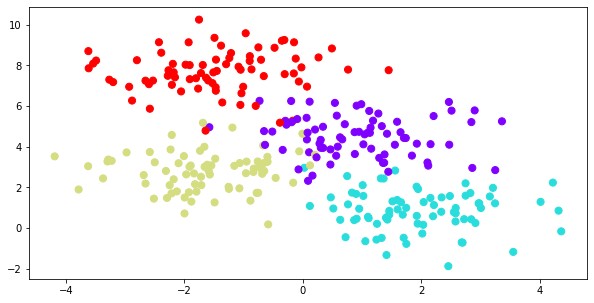

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Construimos, entrenamos y representamos gráficamente las fronteras de decisión de un ensemble de árboles aleatorios de decisión:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'clim'


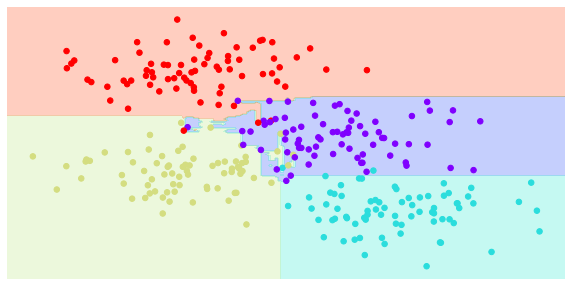

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada modelo con un **subconjunto aleatorio del 80%** de los puntos de entrenamiento. En la práctica, los **árboles de decisión** se aleatorizan en mayor medida, inyectando cierta aleatoriedad en la forma en que se eligen las divisiones: de esta manera todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste siguen teniendo la aleatoriedad deseada. Por ejemplo, al determinar la característica en la que se va a dividir, el árbol aleatorio podría seleccionar entre las varias características principales.



## Random Forest con Scikit-Learn

En *Scikit-Learn*, este conjunto optimizado de árboles de decisión aleatorios se implementa en el modelo `RandomForestClassifier`, que se encarga de toda la aleatorización de forma automática. Todo lo que se necesita es seleccionar un número de estimadores, y el modelo se ajusta en paralelo al conjunto de árboles:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'clim'


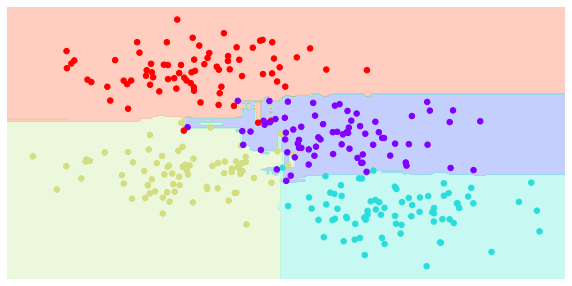

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=1)
visualize_classifier(model, X, y);

Podemos observar que promediando 100 estimadores aleatorios, los cuales probablemente sufran de **overfitting**, obtenemos un modelo que mitiga el efecto de dicha **sobre-estimación**.

## Probando el rendimiento de Random Forest

Para probar el rendimiento de este modelo vamos a utilizar un conjunto de datos sobre imágenes escaneadas de caracteres del alfabeto anglosajón alojado en el [repositorio UCI](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition). 

Según la descripción del *dataset*:

>el objetivo es identificar imágenes rectangulares en blanco y negro como una de las 26 letras mayúsculas del alfabeto inglés. Las imágenes de los caracteres se basaron en 20 fuentes diferentes y cada letra dentro de estas 20 fuentes fue distorsionada aleatoriamente para producir un archivo de 20.000 observaciones únicas.



In [12]:
import pandas as pd
features = [
            'target', 'x-box', 'y-box', 'width', 'high ', 'onpix', 'x-bar',
            'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 
            'xegvy', 'y-ege', 'yegvx'
]
letras = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data', names=features)

X = letras.iloc[:,1:]
y = letras.target

Una vez cargados los datos, procedemos a realizar el ajuste y validación del modelo. Para ello vamos a usar validación cruzada:

In [15]:
from sklearn.model_selection import cross_validate, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=1337)

# Primera aproximación, random forest con parámetros por defecto
rf1 = RandomForestClassifier(n_jobs=-1)

scores = cross_validate(rf1, X, y, cv=cv, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'))

In [16]:
scores

{'fit_time': array([1.93205929, 1.92842412, 1.93154025, 1.91300416, 1.90669799]),
 'score_time': array([0.12710094, 0.12742972, 0.12822199, 0.12864637, 0.13042665]),
 'test_accuracy': array([0.95825, 0.9605 , 0.96425, 0.959  , 0.966  ]),
 'test_precision_weighted': array([0.95868595, 0.96103399, 0.96502187, 0.95952658, 0.96637485]),
 'test_recall_weighted': array([0.95825, 0.9605 , 0.96425, 0.959  , 0.966  ]),
 'test_f1_weighted': array([0.95828815, 0.96048098, 0.96436968, 0.95904373, 0.96602669])}

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

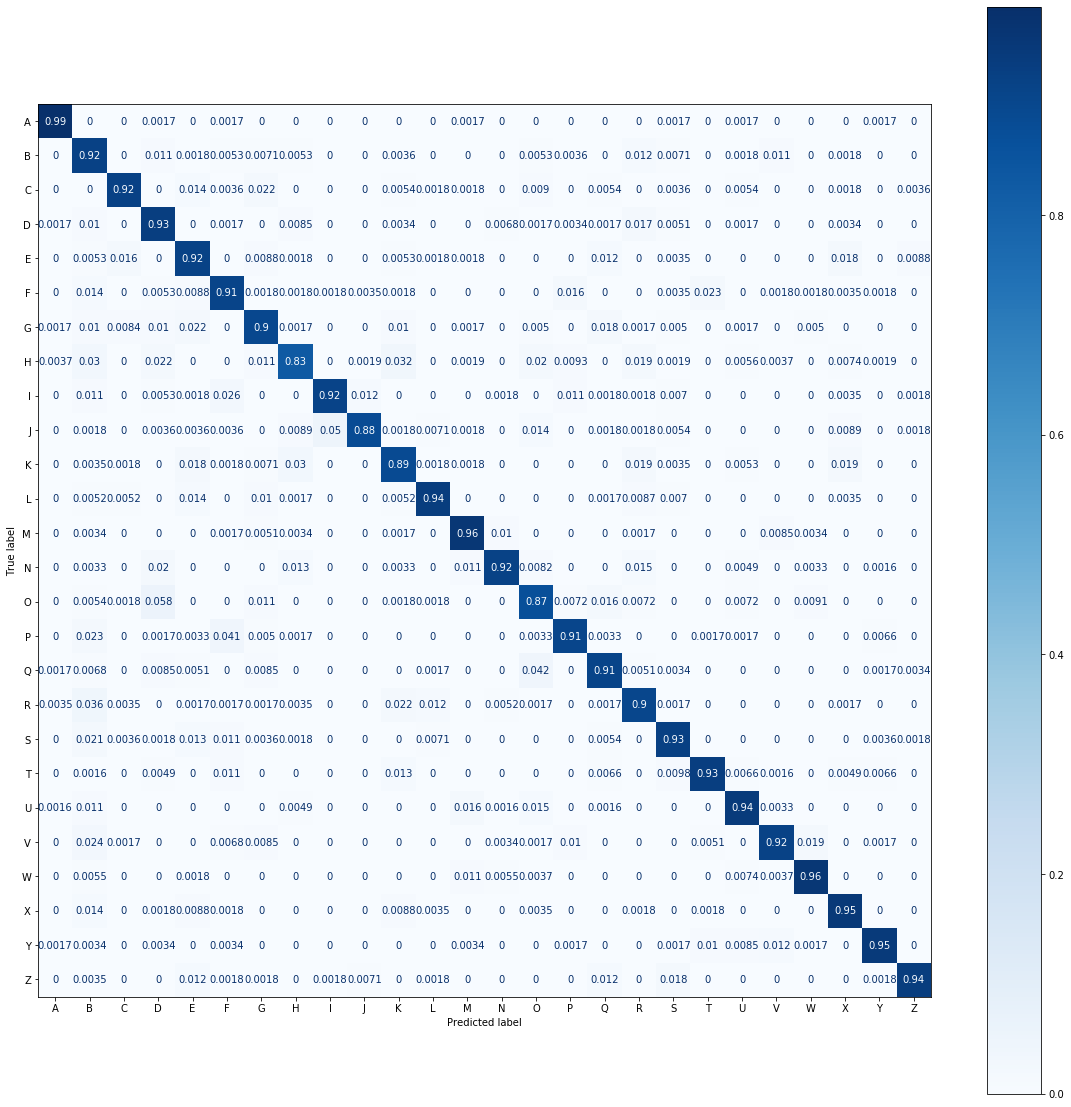

In [26]:
from sklearn.metrics import plot_confusion_matrix

rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)

rf.fit(X_train, y_train)

plt.rcParams["figure.figsize"] = [20, 20]
plot_confusion_matrix(rf, X_test, y_test, cmap='Blues', normalize='true')